In [1]:
import requests
import pandas as pd

API_KEY = 'QC6PHJMTIZHC8S6B'  # Replace with your actual AlphaVantage API key
SYMBOL = 'COST'

url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={SYMBOL}&outputsize=full&apikey={API_KEY}'

response = requests.get(url)
data = response.json()

if 'Time Series (Daily)' in data:
    print("Data fetched successfully.")
else:
    print("Failed to fetch data. Check the API key and symbol.")
    exit()

time_series_data = data['Time Series (Daily)']

# Initialize an empty DataFrame with the desired columns
df = pd.DataFrame(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adjusted Close', 'Volume'])

# Create a list to hold row data before converting it to a DataFrame
rows_list = []

for date, daily_data in time_series_data.items():
    row = {
        'Date': date,
        'Open': daily_data['1. open'],
        'High': daily_data['2. high'],
        'Low': daily_data['3. low'],
        'Close': daily_data['4. close'],
        'Adjusted Close': daily_data['5. adjusted close'],
        'Volume': daily_data['6. volume']
    }
    rows_list.append(row)

# Convert the list of rows into a DataFrame
new_df = pd.DataFrame(rows_list)

# Convert the 'Date' column to datetime and set it as the index
new_df['Date'] = pd.to_datetime(new_df['Date'])
new_df.set_index('Date', inplace=True)

# Sort the DataFrame by the index (Date)
new_df.sort_index(inplace=True)

# Save the DataFrame to a CSV file for future use
new_df.to_csv('data/' + SYMBOL + '.csv')


Data fetched successfully.


In [16]:
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt

# Load the dataset
df = pd.read_csv('data/COST.csv', index_col='Date', parse_dates=True)
# Ensure data is sorted by date
df.sort_index(inplace=True)

# Using 'Close' price for prediction
ts_close = df['Close']


In [17]:
# Define ARIMA model parameters
p = 5  # Number of lag observations
d = 1  # Degree of differencing
q = 0  # Size of moving average window

# Fit the ARIMA model
model = ARIMA(ts_close, order=(p,d,q))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 6106
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -15842.086
Date:                Thu, 08 Feb 2024   AIC                          31696.172
Time:                        06:45:22   BIC                          31736.474
Sample:                             0   HQIC                         31710.155
                               - 6106                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0240      0.005     -4.456      0.000      -0.035      -0.013
ar.L2         -0.0115      0.005     -2.105      0.035      -0.022      -0.001
ar.L3         -0.0110      0.005     -2.269      0.0

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarnin

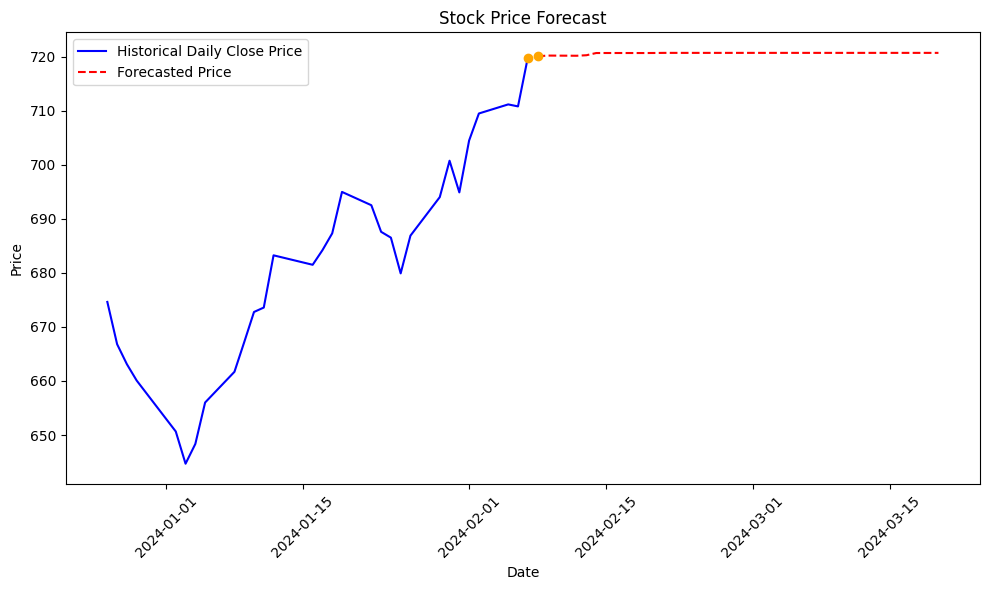

In [34]:
model = ARIMA(df['Close'], order=(5,1,0))  # Replace with your actual order
model_fit = model.fit()

# Get the last date from the historical data
last_date = df.index[-1]

# Forecast the next 30 days
forecast_steps = 30
forecast_values = model_fit.forecast(steps=forecast_steps)

# Create a new index for the forecast values starting the day after the last_date
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='B')

# Create a Series for the forecasted values with the date range as the index
forecast = pd.Series(forecast_values.values, index=forecast_index)

# Slice the last 30 days of historical data
recent_30 = df['Close'][-30:]

# Plot the last 30 days of historical data and the forecast data
plt.figure(figsize=(10, 6))
plt.plot(recent_30.index, recent_30, label='Historical Daily Close Price', color='blue')
plt.plot(forecast.index, forecast, label='Forecasted Price', color='red', linestyle='--')  # Dashed line for forecast

# Highlight the last actual and first forecasted data point for better visual transition
plt.scatter([recent_30.index[-1], forecast.index[0]], [recent_30.iloc[-1], forecast.iloc[0]], color='orange', zorder=5)

# Adjust the x-axis to show dates clearly
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Forecast')
plt.legend()
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()


In [54]:
import pandas as pd

# Load the data
df = pd.read_csv('data/COST.csv', index_col='Date', parse_dates=True)
df.sort_index(inplace=True)
df


,Open,High,Low,Close,Adjusted Close,Volume
Date,,,,,,
1999-11-01,80.00,81.38,78.500,78.56,26.498604,2191100
1999-11-02,79.50,81.88,79.380,80.56,27.173213,2050200
1999-11-03,80.94,83.63,80.750,81.31,27.426191,2344800
1999-11-04,82.56,83.94,81.130,81.38,27.449802,3217400
1999-11-05,82.25,85.63,82.250,85.50,28.839494,2590500
...,...,...,...,...,...,...
2024-02-01,694.00,705.30,691.500,704.48,704.480000,2039177
2024-02-02,703.34,714.28,702.260,709.48,709.480000,2377629
2024-02-05,710.64,712.86,705.675,711.16,711.160000,2276889


In [41]:
# Check for missing values
print(df.isnull().sum())

# Fill missing values if any, here using forward-fill method as an example
df.fillna(method='ffill', inplace=True)

# Remove duplicates
df = df[~df.index.duplicated()]


Open              0
High              0
Low               0
Close             0
Adjusted Close    0
Volume            0
dtype: int64


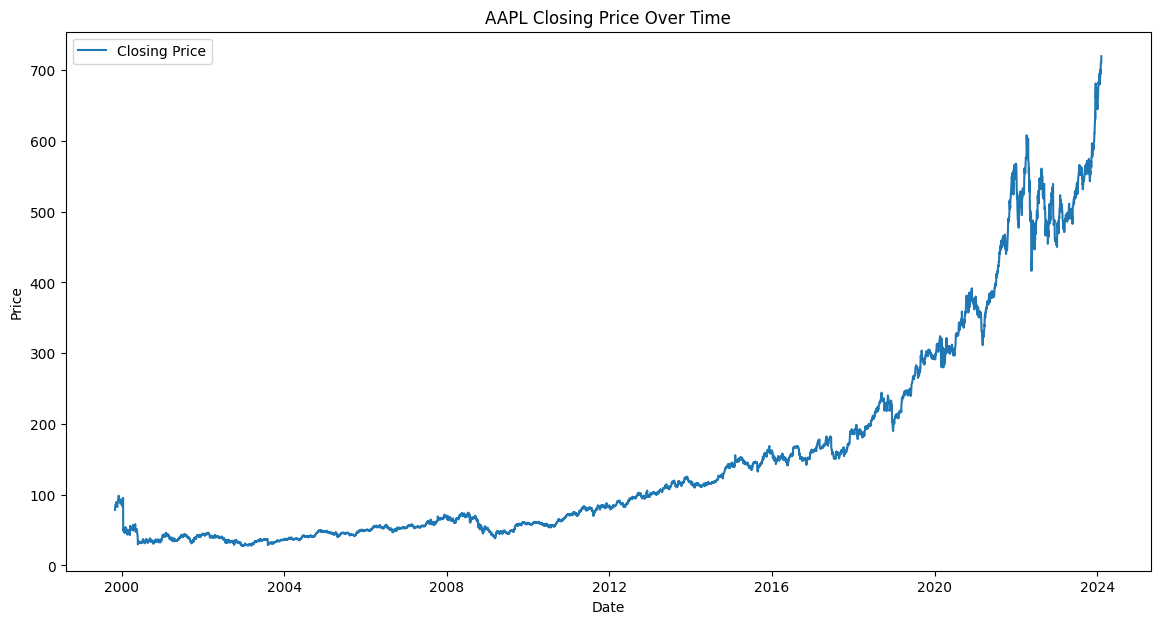

In [42]:
import matplotlib.pyplot as plt

# Plot closing price
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Closing Price')
plt.title('AAPL Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [43]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
adf_test = adfuller(df['Close'])
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])


ADF Statistic: 3.568624
p-value: 1.000000


In [44]:
# Differencing the time series
df['Close_diff'] = df['Close'].diff().dropna()


In [45]:
import pmdarima as pm

# Using auto_arima to find optimal parameters
auto_results = pm.auto_arima(df['Close'], seasonal=False, m=1, d=1, D=1, 
                             start_p=0, start_q=0, max_order=6, test='adf',
                             stepwise=True, trace=True)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=31700.209, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=31698.611, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=31698.515, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=31704.603, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=31699.552, Time=0.83 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=31699.514, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=31701.338, Time=2.47 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=31703.231, Time=0.15 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 4.662 seconds


In [46]:
# Split the data into train and test sets
train = df['Close'][:int(0.85 * len(df))]
test = df['Close'][int(0.85 * len(df)):]


In [47]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model using the optimal parameters
model = ARIMA(train, order=auto_results.order)
model_fit = model.fit()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


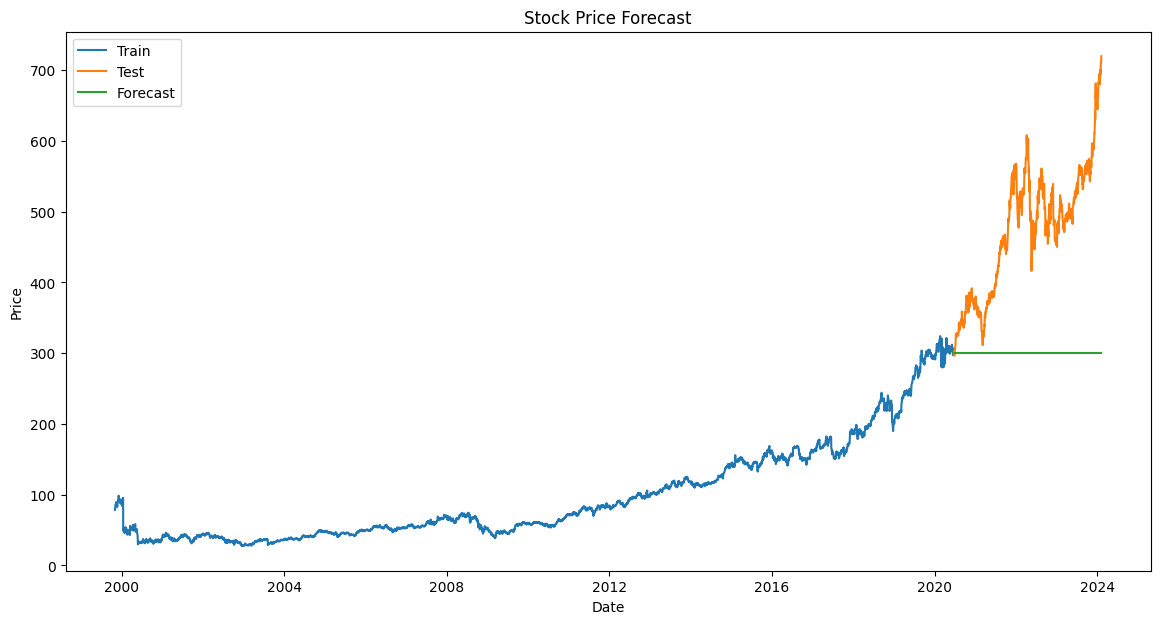

In [48]:
# Forecast
forecast = model_fit.get_forecast(steps=len(test))
forecast_index = test.index
forecast_values = forecast.predicted_mean

# Plot predictions against actual values
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(forecast_index, forecast_values, label='Forecast')
plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/_d/n8yc91k902q2msrhx_h0b_bh0000gn/T/ipykernel_65388/2581866739.py:34: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  forecast_index = pd.da

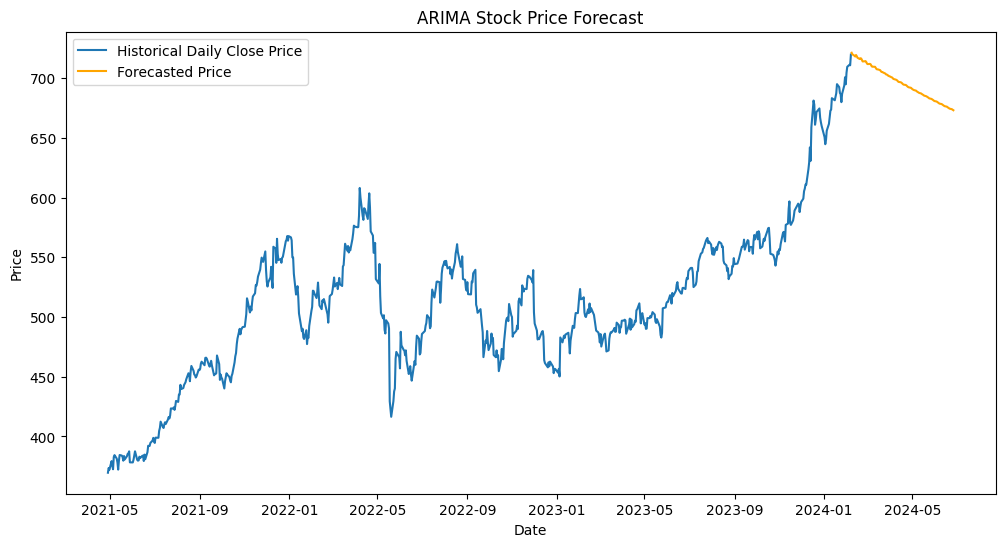

In [80]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load the dataset
df = pd.read_csv('data/COST.csv', index_col='Date', parse_dates=True)
df.sort_index(inplace=True)

# Ensure the 'Close' column is a float and remove any NaNs
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df = df[-700:]
df.dropna(inplace=True)

# Set the frequency of the DataFrame index to business days
df.index = df.index.to_period('B')

# Define the ARIMA model parameters
p = 7  # Replace with your chosen value
d = 0  # Replace with your chosen value (usually 1, since stock prices are rarely stationary)
q = 6  # Replace with your chosen value

# Fit the ARIMA model
model = ARIMA(df['Close'], order=(p, d, q))
model_fit = model.fit()

# Forecast the next 30 business days
forecast_steps = 100
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean

# Convert the forecast index to datetime, as required for plotting
forecast_index = pd.date_range(df.index[-1].to_timestamp(), periods=forecast_steps+1, closed='right', freq='B')

# Calculate the root mean squared error (RMSE) for the predictions
# Note: This requires actual future values to compare against, which may not be available yet
# If you have a test set, you can calculate RMSE as follows
# rmse = sqrt(mean_squared_error(test_set, forecast_values))
# print(f'Test RMSE: {rmse:.3f}')

# Plot the historical data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index.to_timestamp(), df['Close'], label='Historical Daily Close Price')
plt.plot(forecast_index, forecast_values, label='Forecasted Price', color='orange')
plt.title('ARIMA Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


Text(0, 0.5, 'Return')

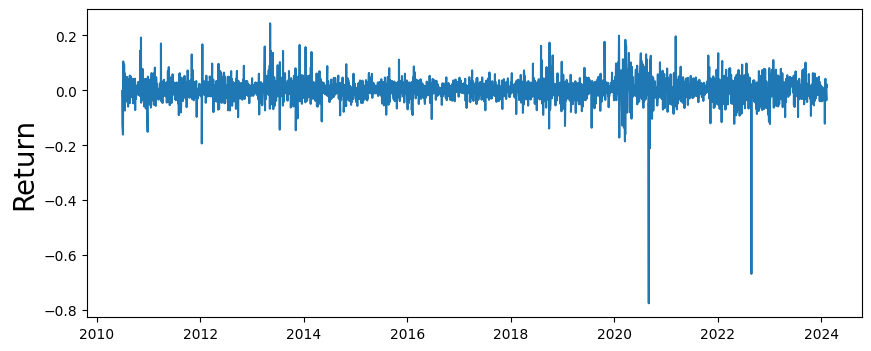

In [87]:
returns = df["Close"].pct_change().dropna()

plt.figure(figsize = (10, 4))
plt.plot(returns)
plt.ylabel("Return", fontsize = 20)



In [82]:
forecast

3426    187.660611
3427    187.592291
3428    187.179864
3429    187.377860
3430    187.526986
3431    187.532094
3432    187.527494
3433    187.502941
3434    187.512391
3435    187.521297
3436    187.521672
3437    187.521375
3438    187.519927
3439    187.520361
3440    187.520889
3441    187.520918
3442    187.520900
3443    187.520815
3444    187.520834
3445    187.520865
3446    187.520867
3447    187.520866
3448    187.520861
3449    187.520862
3450    187.520864
3451    187.520864
3452    187.520864
3453    187.520864
3454    187.520864
3455    187.520864
Name: predicted_mean, dtype: float64